In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataloader import prepare_data_loader
from obspy import read
from scipy import signal
from matplotlib import cm
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [4]:
training_data_dir = './data/lunar/training/data/S12_GradeA/'
training_labels_file = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'

train_loader = prepare_data_loader(overlap=0.25,
                                  window_length=1,
                                  decimation_factor=3,
                                  spect_nfft=128,
                                  spect_nperseg=128,
                                  batch_size=128,
                                  data_dir=training_data_dir,
                                  labels_file_path=training_labels_file)

test_data_dir = './data/lunar/test/data/S12_GradeB/'

test_loader = prepare_data_loader(overlap=0.25,
                                  window_length=1,
                                  decimation_factor=3,
                                  spect_nfft=128,
                                  spect_nperseg=128,
                                  batch_size=128,
                                  data_dir=test_data_dir)

Starting number of files:76
Number of uniques files:71
(6633, 65, 70)
(6633,)
Number of windows with seismic event 299
Noise sample weight: 0.04507764209256747
Event sample weight: 0.9549223579074325
Starting number of files:64
Number of uniques files:62
(5736, 65, 70)


In [5]:
height, width = train_loader.dataset.tensors[0].shape[1:]

In [27]:
classifier = Classifier().to(device)
encoder = torch.load('./models/encoder.pth', weights_only=False)
# encoder = encoder.to(device)
model.load_state_dict(torch.load('./models/encoder.pth', weights_only=True))

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.L1Loss()

In [ ]:
num_epochs = 100
all_losses = []
classifier.train()
for epoch in range(num_epochs):
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        embedding = encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        preds = classifier(embedding)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch [{epoch + 1}/{num_epochs}], loss: {loss.item()}')

torch.save(classifier, './models/classifier.pth')
plt.plot(all_losses)
plt.yscale('log')
plt.show()

In [9]:
test_data_dir = './data/lunar/test/data/S12_GradeB/'

spctrs, dates = prepare_data_loader(overlap=0.25,
                                  window_length=1,
                                  decimation_factor=3,
                                  spect_nfft=128,
                                  spect_nperseg=128,
                                  batch_size=128,
                                  data_dir=test_data_dir,
                                  one_file=True)

Starting number of files:64
Number of uniques files:62
(5736, 65, 70)


In [28]:
classifier.eval()
for spc, date in zip(spctrs, dates):
    spc = torch.tensor(spc).to(device)
    embedding = encoder(spc)
    embedding = embedding.view(embedding.size(0), -1)
    preds = classifier(embedding)

TypeError: 'collections.OrderedDict' object is not callable

In [20]:
num_file = 7
data_directory = './data/lunar/test/data/S12_GradeB/'
for i, file in enumerate(os.listdir(data_directory)):
    if file.endswith('.mseed'):
        if i // 2 == num_file:
            print(file)
            mseed_file = f'{data_directory}{file}'
            st = read(mseed_file)
            break

xa.s12.00.mhz.1970-05-20HR00_evid00026.mseed


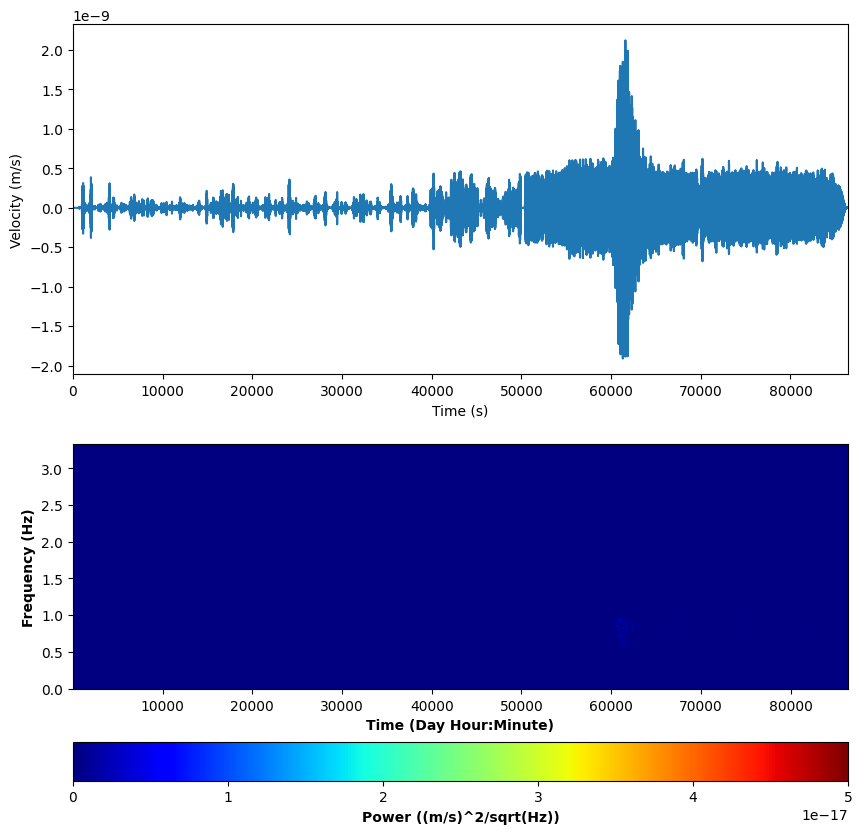

In [21]:
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=0.5, freqmax=1.0)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
ax.plot(tr_times_filt,tr_data_filt)

ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')